# Historical Diagram Vectorization

This notebook builds on the notebook provided in the DINO repository. 

We provide this notebook for inference and visualizations. 
You can either load images from a dataloader(see Sec. 1) or from a local path(see Sec. 2).

In [1]:
import os
import torch, json
import numpy as np
import matplotlib.pyplot as plt
import glob

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops
from pathlib import Path
from torch import nn
from PIL import Image
import datasets.transforms as T


# 0. Initialize and Load Pre-trained Model

In [2]:
log_path = Path('../logs/')
model_folder = log_path / "main_model" # change the path of the model folder
model_config_path = f"{model_folder}/config_cfg.py" # change the path of the model config file
epoch = '0036' 
model_checkpoint_path = f"{model_folder}/checkpoint{epoch}.pth"
args = SLConfig.fromfile(model_config_path) 
args.device = 'cpu' 

In [ ]:
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

# 1. Visualize images from a dataloader
## 1.1 Load Datasets

In [4]:
image_set = "val"
args.eval = image_set == "val"
args.coco_path = "data/synthetic_processed"
args.batch_size = 1
args.on_the_fly_val = True
dataset_val  = build_dataset(image_set=image_set, args=args)   


################## data/synthetic_processed


## 1.2 Get an Example and Visualize it

In [5]:
vslzr = COCOVisualizer()
id2name = {0: 'line', 1: 'circle', 2: 'arc'}

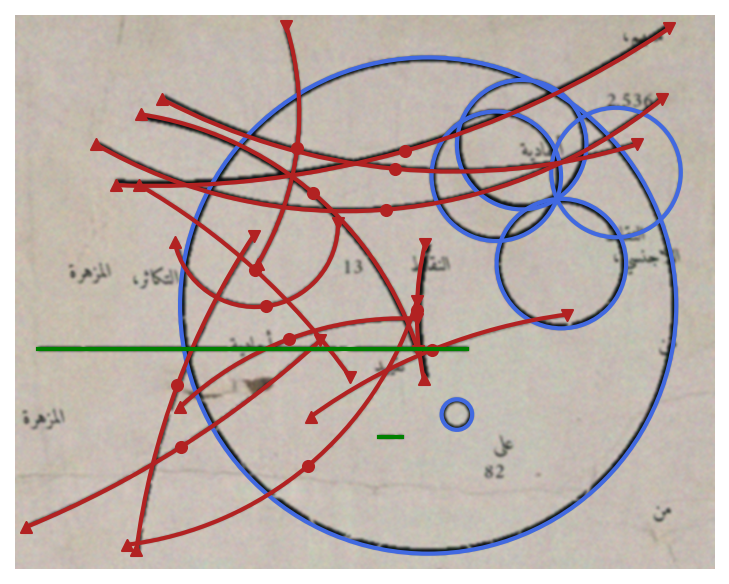

In [6]:
image, targets = dataset_val[0]
box_label = [id2name[int(item)] for item in targets['labels']]

gt_dict = {
    'parameters': targets['parameters'],
    'image_id': targets['image_id'],
    'size': targets["size"],
    'labels': box_label,
    # 'colors':["#70C370", "red","royalblue", "#FFFF00" ],
}
primitives_to_show = ['line', 'circle', 'arc']
vslzr.visualize(image, gt_dict,  primitives_to_show=primitives_to_show, show_boxes = False, dpi=150, show_text=False)


## 1.3 Visualize Model Predictions

In [7]:
output = model.cuda()(image[None].cuda())


/home/kallelis/miniconda3/envs/testing-DV/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
encoder_only = False
if encoder_only: # if you would like to visualize the intermediary results of the encoder
    encoder_only_output = output['interm_outputs']
    output = postprocessors['param'](encoder_only_output, torch.Tensor([[1.0, 1.0]]).cuda(), to_xyxy=False)[0]
else:
    output = postprocessors['param'](output, torch.Tensor([[1.0, 1.0]]).cuda(), to_xyxy=False)[0]

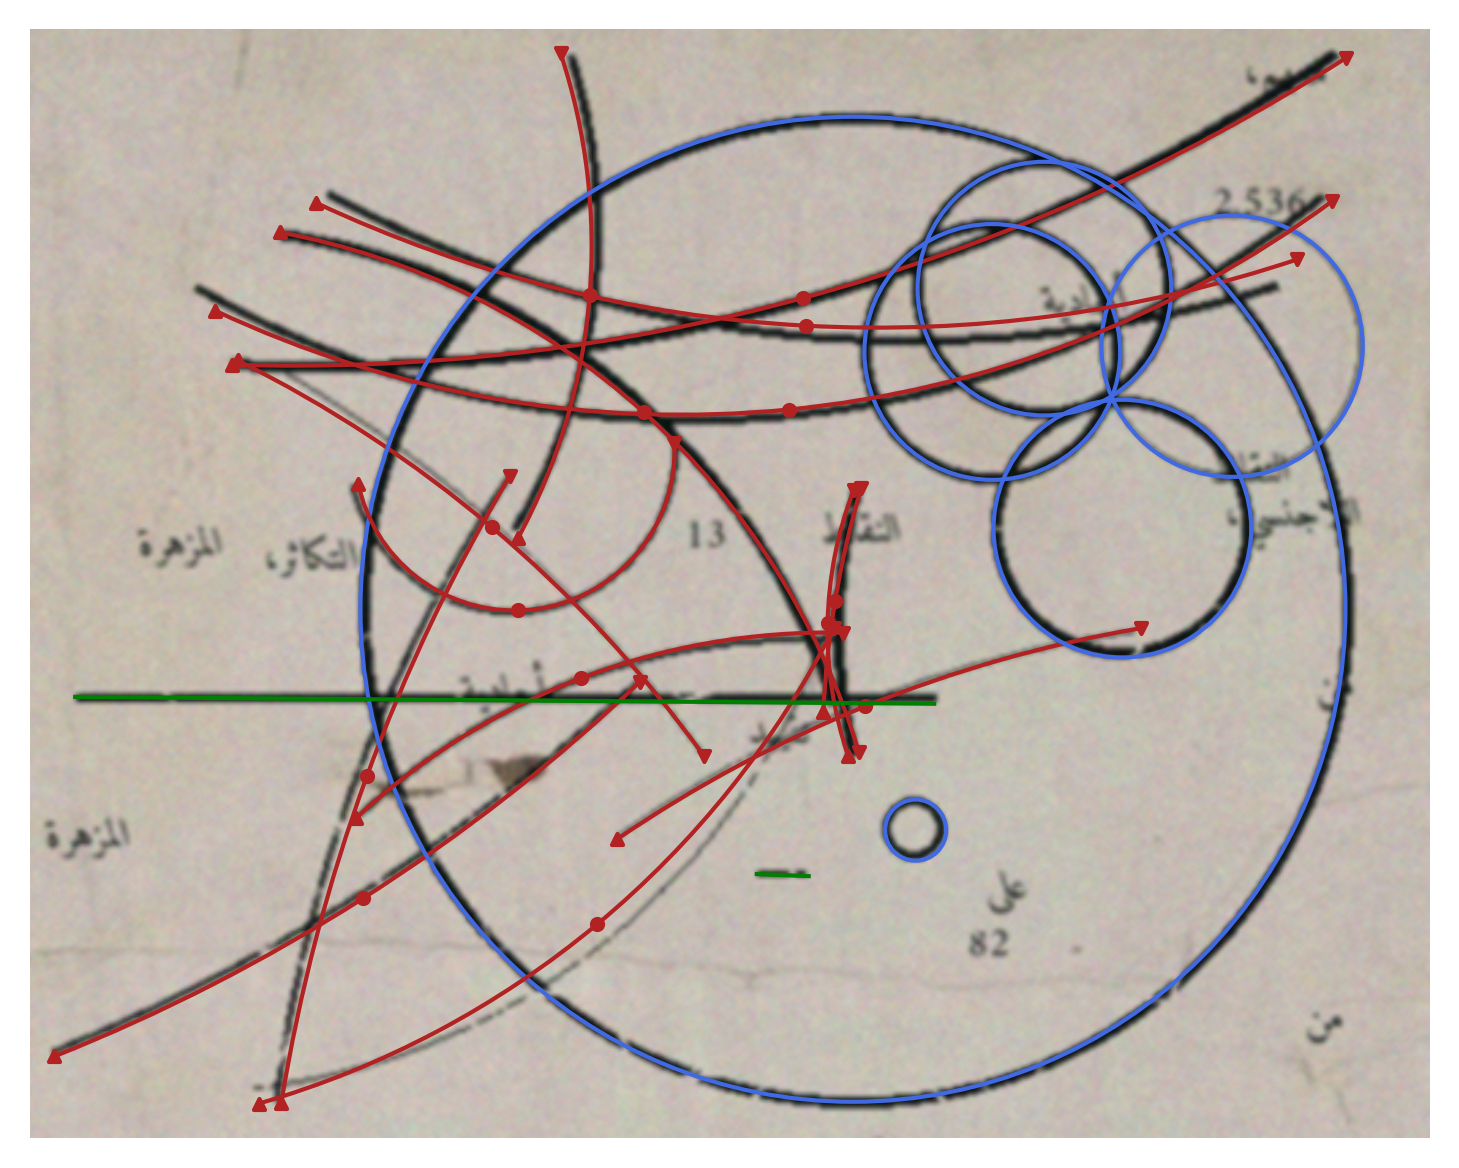

In [9]:
thershold = 0.3
primitives_to_show = ['arc']
scores = output['scores']
labels = output['labels']
boxes = output['parameters']
select_mask = scores > thershold
box_label = [id2name[int(item)] for item in labels[select_mask]]

cmap = plt.get_cmap('tab20')
pred_dict = {
    'parameters': boxes[select_mask],
    'size': targets['size'],
    'labels': box_label,
    'scores': scores, 
}
primitives_to_show = ['line', 'circle', 'arc']
vslzr.visualize(image, pred_dict, primitives_to_show=primitives_to_show,  show_boxes=False, show_text=False, dpi=300, linewidth=1)

# 2. Visualize Custom Images

In [10]:
image_dir = Path("../data/eida_dataset/images/")
all_image_paths = list(image_dir.glob('*.jpg'))
image_path = all_image_paths[0]


In [11]:
def visualize_pred(image_path, show_in_console,savedir = None, save_separately=False, dpi=100, show_image=True,threshold=0.3, show_boxes = True, flip_image=False, show_text=False, linewidth=2):
    img_name = os.path.basename(image_path)
    image = Image.open(image_path).convert("RGB") # load image

    transform = T.Compose([
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image, _ = transform(image, None)
    size = torch.Tensor([image.shape[1], image.shape[2]])
    
    output = model.cuda()(image[None].cuda())    

    if encoder_only:
        encoder_only_output = output['interm_outputs']
        output = postprocessors['param'](encoder_only_output, torch.Tensor([[1.0, 1.0]]).cuda(), to_xyxy=False)[0]
    else:
        output = postprocessors['param'](output, torch.Tensor([[1.0, 1.0]]).cuda(), to_xyxy=False)[0]
    scores = output['scores']
    labels = output['labels']
    boxes = output['parameters']
    select_mask = (scores > threshold)
    box_label = [id2name[int(item)] for item in labels[select_mask]]
    boxes = boxes[select_mask]

    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in range(cmap.N)]

    
    pred_dict = {
        'parameters': boxes,
        'size': size,
        'labels': box_label,
        'scores': scores, 
        # 'colors':colors,
    }
    primitives_to_show = ['line', 'circle', 'arc']
    vslzr.visualize(image, pred_dict, primitives_to_show=primitives_to_show, show_boxes=show_boxes, show_text=show_text,  show_image = show_image, savedir = savedir , img_name = img_name, dpi = dpi, linewidth=linewidth)


    return pred_dict

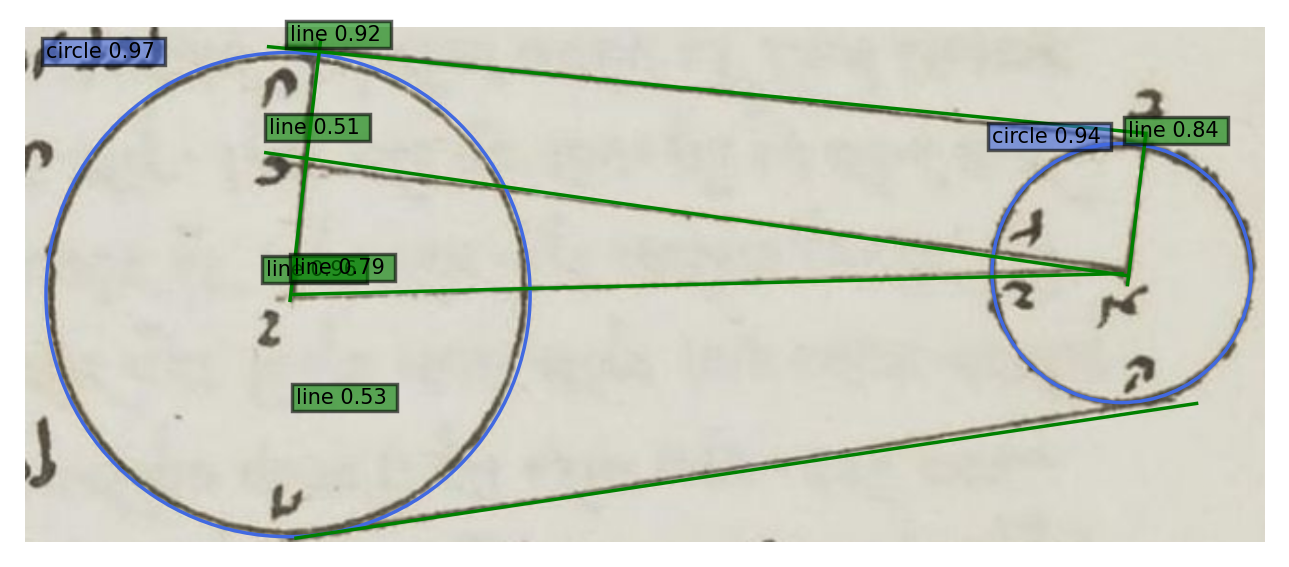

In [12]:
pred_dict = visualize_pred(image_path, show_in_console=True, dpi=250, show_image=True, threshold=0.3, show_boxes = False, show_text=True, linewidth=1)